In [50]:
import tensorflow as tf
import numpy as np
import cv2


# I like to resize MNIST from 28px to 32px
def resize(mnist):
     train_data = []
     for img in mnist:
            resized_img = cv2.resize(img, (32, 32))
            train_data.append(resized_img)
     return train_data

(xtrain, train_target), (_, _) = tf.keras.datasets.mnist.load_data()

xtrain = xtrain[0:200]
train_target = train_target[0:200]

xtrain = resize(xtrain)

xtrain = np.expand_dims(xtrain, axis=-1)
xtrain = np.repeat(xtrain, 3, axis=-1)
xtrain = xtrain.astype('float32') / 255
print(xtrain.shape)

# 10 categories, one for each digit
ytrain1 = tf.keras.utils.to_categorical(train_target, num_classes=10)

# 2 categories, if the digit is odd or not
ytrain2 = tf.keras.utils.to_categorical((train_target % 2 == 0).astype(int), 
                                        num_classes=2)

# 4 categories, based on the interval of the digit
ytrain3 = tf.keras.utils.to_categorical(np.digitize(train_target, [3, 6, 8]), 
                                        num_classes=4)

(200, 32, 32, 3)


In [51]:
xtrain[0:200].shape

(200, 32, 32, 3)

In [39]:
# declare input shape 
input = tf.keras.Input(shape=(32,32,3))
# Block 1
base_model = tf.keras.applications.VGG16(include_top = False, 
                                                  weights='imagenet', 
                                         input_tensor=input)
x = base_model.output
# Now that we apply global max pooling.
gap = tf.keras.layers.GlobalMaxPooling2D()(x)

# Finally, we add a classification layer.
last_dense1 = tf.keras.layers.Dense(10, activation='softmax', name='10Class')(gap)
last_dense2 = tf.keras.layers.Dense(2, activation='softmax', name='2Class')(gap)
last_dense3 = tf.keras.layers.Dense(4, activation='softmax', name='4Class')(gap)

# bind all
func_model = tf.keras.Model(input, [last_dense1, last_dense2, last_dense3])

# compile and fit (to get some optimized weight)
func_model.compile(
   optimizer = tf.keras.optimizers.Adam(),

   loss = {'10Class' : 'categorical_crossentropy', 
            '2Class' : 'categorical_crossentropy', 
             '4Class': 'categorical_crossentropy'},
   metrics={'10Class' : 'accuracy', 
            '2Class' : 'accuracy', 
            '4Class': 'accuracy'}
    )

func_model.fit(xtrain, [ytrain1, ytrain2,  ytrain3], 
               epochs=5)

Epoch 1/2
7/7 [==============================] - 21s 3s/step - loss: 4.7171 - 10Class_loss: 2.3891 - 2Class_loss: 0.7510 - 4Class_loss: 1.5769 - 10Class_accuracy: 0.1250 - 2Class_accuracy: 0.5150 - 4Class_accuracy: 0.2100
Epoch 2/2
7/7 [==============================] - 23s 3s/step - loss: 4.5364 - 10Class_loss: 2.3868 - 2Class_loss: 0.7658 - 4Class_loss: 1.3838 - 10Class_accuracy: 0.0850 - 2Class_accuracy: 0.4100 - 4Class_accuracy: 0.3250


In [40]:
for layer in base_model.layers:
    print(layer.name) 

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [41]:
last_conv = base_model.layers[-3]  # block5_conv2

last_dense1 = func_model.layers[-3] # 10 classifier
last_dense2 = func_model.layers[-2] #  2 classifier 
last_dense3 = func_model.layers[-1] #  4 classifier

last_dense1_weights = last_dense1.get_weights()[0]
last_dense2_weights = last_dense2.get_weights()[0]
last_dense3_weights = last_dense3.get_weights()[0]
dense_layer_weights_list = [last_dense1_weights,
                            last_dense2_weights, 
                            last_dense3_weights]

model_cam = tf.keras.Model(inputs = input,
                           outputs = (last_conv.output,
                                      last_dense1.output,
                                      last_dense2.output,
                                      last_dense3.output),
                           name = 'CAM_model')

In [42]:
features, preds1, preds2, preds3 = model_cam.predict(xtrain)

print(f'{features.shape}')
print(f'{preds1.shape}')
print(f'{preds2.shape}')
print(f'{preds3.shape}')

# (60000, 2, 2, 512)
# (60000, 10)
# (60000, 2)
# (60000, 4)

(200, 2, 2, 512)
(200, 10)
(200, 2)
(200, 4)


In [47]:
raw_preds_list = [preds1, preds2, preds3]

In [48]:
import scipy
import matplotlib.pyplot as plt 

ImgSize  = 32 # Image dimention 
FeatMaps = 42 # No of feature maps

def showing_cam(img, 
                img_arrays, 
                features=features, 
                raw_preds_list=raw_preds_list, 
                dense_layer_weights_list=dense_layer_weights_list):
    
    features_for_img = features[img,:,:,:]
    
    root_preds = np.argmax(raw_preds_list[0][img])
    print(root_preds)
    vowel_preds = np.argmax(raw_preds_list[1][img])
    consonant_preds = np.argmax(raw_preds_list[2][img])
    predicted_img_list = [root_preds, vowel_preds, consonant_preds]
    
    preds_root_round = np.round(raw_preds_list[0][img][root_preds], 3)
    preds_vowel_round = np.round(raw_preds_list[1][img][vowel_preds], 3)
    preds_consonant_round = np.round(raw_preds_list[2][img][consonant_preds], 3)
    
    # Upscaling those features to the size of the image:
    scale_factor_height = ImgSize/features[FeatMaps,:,:,:].shape[0]
    scale_factor_width = ImgSize/features[FeatMaps,:,:,:].shape[1]
    
    upscaled_features = scipy.ndimage.zoom(features[img,:,:,:], 
                                           (scale_factor_height, scale_factor_width, 1), 
                                           order=1)
    
    prediction_for_img = []
    cam_weights = []
    cam_output = []
    
    for symbol in range(3):
        prediction_for_img.append(predicted_img_list[symbol])
        cam_weights.append(dense_layer_weights_list[symbol][:,prediction_for_img[symbol]])
        cam_output.append(np.dot(upscaled_features, cam_weights[symbol]))
    
    fig, (ax0, ax1, ax2, ax3) = plt.subplots(1, 4, figsize=(15, 10))
    
    squeezed_img = np.squeeze(img_arrays[img]) #, axis=0)
    
    ax0.imshow(squeezed_img, cmap='Greys')
    ax0.set_title("Original image")
    
    ax1.imshow(squeezed_img, cmap='Greys', alpha=0.5)
    ax1.imshow(cam_output[0], cmap='jet', alpha=0.5)
    ax1.set_title('CAM_10 {} w/prob {:.2f}'.format(root_preds,preds_root_round ))
    
    ax2.imshow(squeezed_img, cmap='Greys', alpha=0.5)
    ax2.imshow(cam_output[1], cmap='jet', alpha=0.5)
    ax2.set_title('CAM_2 {} w/prob {:.2f}'.format(vowel_preds,preds_vowel_round ))

    ax3.imshow(squeezed_img, cmap='Greys', alpha=0.5)
    ax3.imshow(cam_output[2], cmap='jet', alpha=0.5)
    ax3.set_title('CAM_4 {} w/prob {:.2f}'.format(consonant_preds,preds_consonant_round ))
    plt.show()

In [45]:
np.argmax(raw_preds_list[0][img])

1891

6


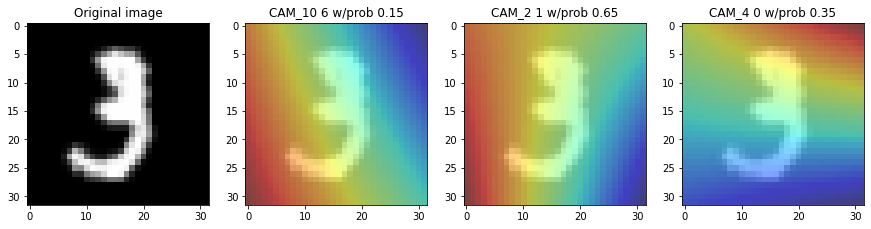

1


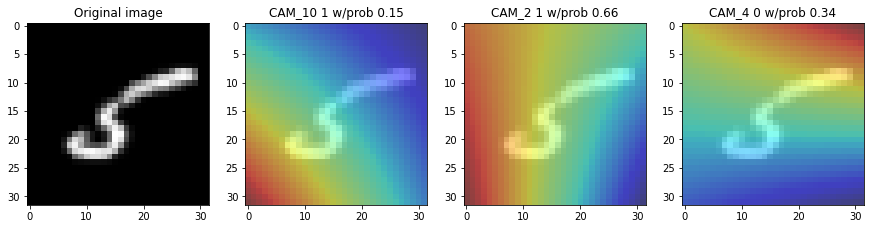

6


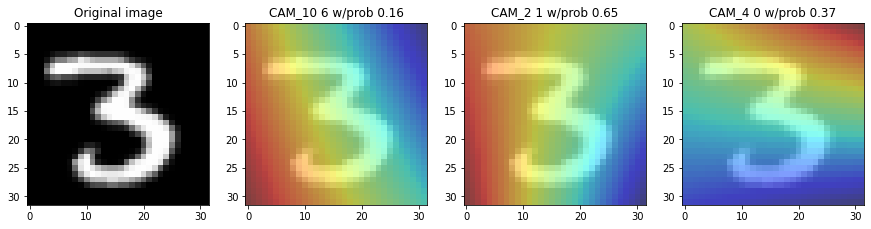

6


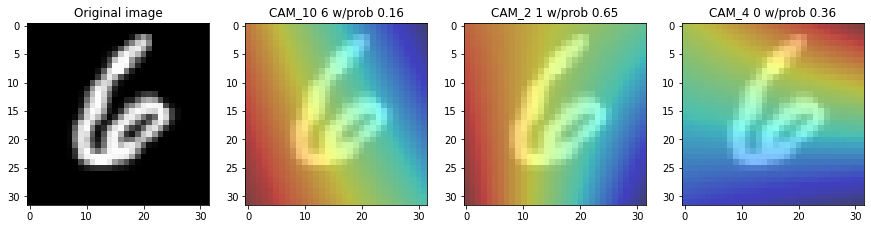

1


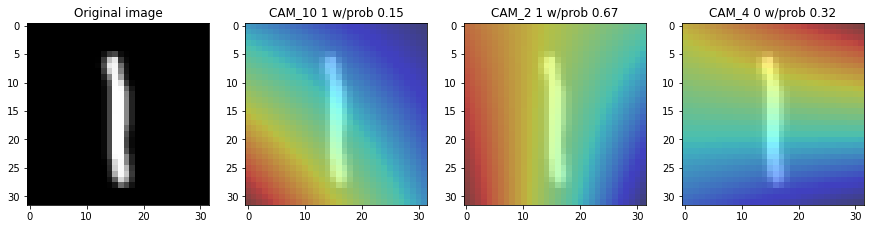

In [49]:
for img in range(10,15):
    showing_cam(img, img_arrays=xtrain)